In [396]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [397]:
df = pd.read_csv('train.csv')

In [398]:
df.head(3)

,ID,STAY_DRG_CD,STAY_FROM_DT,STAY_THRU_DT,STUS_CD,TYPE_ADM,SRC_ADMS,AD_DGNS,DGNSCD01,PRCDRCD01,...,DGNSCD22,PRCDRCD22,DGNSCD23,PRCDRCD23,DGNSCD24,PRCDRCD24,DGNSCD25,PRCDRCD25,stay_drg_cd,Readmitted_30
0,17319,NaN,2017-12-13 00:00:00,2017-12-20 00:00:00,62,1,2,M25551,S72001A,0SRR01Z,...,Z803,NaN,Z86711,NaN,Z86718,NaN,Z85828,NaN,469,0
1,19722,NaN,2017-10-19 00:00:00,2017-10-23 00:00:00,1,1,1,R531,A419,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,871,1
2,89699,NaN,2018-08-06 00:00:00,2018-08-08 00:00:00,1,1,1,R002,J690,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177,0


In [399]:
df.shape

(130296, 60)

In [400]:
df.duplicated().sum()

np.int64(0)

In [401]:
# engineering of diagnostic and procedure features
# apply all three methods 

# Pre-processing

#### Checking Nulls

**Percentage of nulls**

In [402]:
# while exploring the data, we found that some columns contain '-' token as null value, so replace it with null

df = df.replace('-', pd.NA)

In [403]:
nulls = df.isna().sum()

Trows = df.shape[0] # number of rows in the dataset


# sort the nulls in descending order
nulls = nulls[nulls > 0].sort_values(ascending=False)
for i in nulls.index:
    if nulls[i] > 0:
        print(f"{i} has {(nulls[i]/Trows)*100}% null values")



PRCDRCD25 has 99.98234788481611% null values
PRCDRCD24 has 99.9739055688586% null values
PRCDRCD23 has 99.96623073616995% null values
PRCDRCD22 has 99.95548597040585% null values
PRCDRCD21 has 99.94474120464174% null values
PRCDRCD20 has 99.93169398907104% null values
PRCDRCD19 has 99.91557684042488% null values
PRCDRCD18 has 99.89178485909007% null values
PRCDRCD17 has 99.86876036102413% null values
PRCDRCD16 has 99.83345613065634% null values
PRCDRCD15 has 99.78280223491129% null values
PRCDRCD14 has 99.6953091422607% null values
PRCDRCD13 has 99.59630380057715% null values
PRCDRCD12 has 99.46352919506354% null values
PRCDRCD11 has 99.2839381101492% null values
PRCDRCD10 has 99.01915638239086% null values
PRCDRCD09 has 98.71062810830725% null values
PRCDRCD08 has 98.24399828083747% null values
PRCDRCD07 has 97.49186467735004% null values
STAY_DRG_CD has 97.08509854485172% null values
PRCDRCD06 has 95.84331061582857% null values
PRCDRCD05 has 93.59458463805488% null values
PRCDRCD04 h

In [404]:
# count coulmns greater than 50% null values
nulls_50 = nulls[nulls > (Trows*0.5)]
print(f"Columns with more than 50% null values: {len(nulls_50)}")
# count coulmns greater than 50% null values
nulls_60 = nulls[nulls > (Trows*0.6)]
print(f"Columns with more than 60% null values: {len(nulls_60)}")
# count coulmns greater than 70% null values
nulls_70 = nulls[nulls > (Trows*0.7)]
print(f"Columns with more than 70% null values: {len(nulls_70)}")
# count coulmns greater than 80% null values
nulls_80 = nulls[nulls > (Trows*0.8)]
print(f"Columns with more than 80% null values: {len(nulls_80)}")

Columns with more than 50% null values: 34
Columns with more than 60% null values: 31
Columns with more than 70% null values: 29
Columns with more than 80% null values: 25


In [405]:
# Findings:
#     most of the nulls are in diagnostic and procedure features

    

#### STAY_DRG_CD
This column appeared twice in our dataset, rows which are null in first occurenece are filled in second and vice versa so concatenating them


In [406]:
print("STAY_DRG_CD null count:", df['STAY_DRG_CD'].isna().sum())
print("stay_drg_cd null count:", df['stay_drg_cd'].isna().sum())

STAY_DRG_CD null count: 126498
stay_drg_cd null count: 8163


In [407]:
# Fill the null values in STAY_DRG_CD with values from stay_drg_cd
df['STAY_DRG_CD'] = df['STAY_DRG_CD'].fillna(df['stay_drg_cd'])

In [408]:
nulls_in_SDC = df['STAY_DRG_CD'].isna().sum()

rows = df.shape[0]

print(f'Nulls in STAY_DRG_CD are: {nulls_in_SDC} which is {(nulls_in_SDC/rows)*100}% of total data',)

Nulls in STAY_DRG_CD are: 4365 which is 3.3500644685945846% of total data


In [409]:
# fill na with mode

df['STAY_DRG_CD'] = df['STAY_DRG_CD'].fillna(df['STAY_DRG_CD'].mode()[0])

In [410]:
df.drop(columns=['stay_drg_cd'], inplace=True)

In [411]:
df['STAY_DRG_CD'] = df['STAY_DRG_CD'].astype('int')


#### ID

In [412]:
# let's verify if there is any correlation between the readmission and ID by training a simple model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X = df[['ID']]
y = df['Readmitted_30']

model = LogisticRegression()
model.fit(X, y)

pred_probs = model.predict_proba(X)[:, 1]
auc = roc_auc_score(y, pred_probs)
print(f"ROC AUC score using only ID: {auc}")


ROC AUC score using only ID: 0.5061388586764188


In [413]:
# An ROC AUC score of ~0.506 means that the ID feature has no real predictive power for the target variable — it’s basically performing at random chance level (0.5)


# so we can drop it.

In [414]:
df.drop(columns=['ID'], inplace=True)

#### Date

In [415]:
# we have admitted date and discharge date, we can calculate the length of stay for each patient.

df['STAY_FROM_DT'] = pd.to_datetime(df['STAY_FROM_DT'])
df['STAY_THRU_DT'] = pd.to_datetime(df['STAY_THRU_DT'])

In [416]:
df['LENGTH_OF_STAY'] = (df['STAY_THRU_DT'] - df['STAY_FROM_DT']).dt.days

In [417]:

df['admit_dayofweek'] = df['STAY_FROM_DT'].dt.dayofweek

df['discharge_month'] = df['STAY_THRU_DT'].dt.month

# Why it matters:
#   Discharges on Fridays/Saturdays might mean less follow-up planning → more readmissions.
#   Certain months (e.g., flu season) might show patterns in readmissions.


In [418]:
df['LENGTH_OF_STAY'].isna().sum()

np.int64(0)

In [419]:
df.drop(columns=['STAY_FROM_DT','STAY_THRU_DT'], inplace=True)

#### STUS_CD - Patient Discharge Status code

In [420]:
# Extremely useful. Discharge to a skilled nursing facility, hospice, or readmission facility often signals poor outcomes → high chance of readmission.

In [421]:
df['STUS_CD'].value_counts()

STUS_CD
1     56886
3     40498
6     22420
62     6131
63     4361
Name: count, dtype: int64

In [422]:
df.groupby('STUS_CD')['Readmitted_30'].mean()
# patient with code 3,6 have slightly more change to come back to hospital.

STUS_CD
1     0.185775
3     0.229024
6     0.231401
62    0.183657
63    0.124054
Name: Readmitted_30, dtype: float64

In [423]:
# This code describes how and where the patient was discharged, for example:

# 1 – Discharged to home/self-care
# 3 – Discharged/transferred to SNF (Skilled Nursing Facility)
# 6 – Discharged/transferred to home with home health services
# 62 – Discharged/transferred to inpatient rehabilitation
# 63 – Discharged/transferred to long-term hospital

# These are standard CMS codes


# STUS_CD is a categorical code, not a numeric measurement. so no need to normalize it, but we can encode it using label encoding. (ordinal encoding)


In [424]:
df['STUS_CD'].isna().sum()

np.int64(0)

In [425]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['STUS_CD_encoded'] = le.fit_transform(df['STUS_CD'])
df.drop(columns=['STUS_CD'], inplace=True)

#### TYPE_ADM - Admission Type code

In [426]:
# How the patient was admitted — e.g., elective, emergency, urgent, newborn, etc.

# 1 – Elective admission
# 2 – Emergency admission
# 3 – Urgent admission
# 5 – Newborn admission
# 9 – Other admission type

# as this is again a categorical column so no need to normalize, we can encode it using label encoding.

In [427]:
# Clinically, this feature is very important, as it often correlates with the urgency of the condition and thus the likelihood of readmission.

# Emergency or urgent admissions generally carry higher readmission risks compared to planned, elective ones.

In [428]:
df['TYPE_ADM'].value_counts()

TYPE_ADM
1    108830
3     11993
2      9259
5       145
9        69
Name: count, dtype: int64

In [429]:
df['TYPE_ADM'].isna().sum()

np.int64(0)

In [430]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['TYPE_ADM_encoded'] = le.fit_transform(df['TYPE_ADM'])

df.drop(columns=['TYPE_ADM'], inplace=True)

#### SRC_ADMS - admission source code

In [431]:
df['SRC_ADMS'].value_counts()

SRC_ADMS
1    106269
5     12946
2     11081
Name: count, dtype: int64

In [432]:
# Again a categorical column. 

# This feature indicates the source of the admission, such as:
# The admission source indicates where the patient came from before being admitted to the hospital. Typical codes might represent:

# 1 – Emergency room (ER)
# 2 – Referral from another hospital or clinic
# 5 – Other sources (e.g., physician's office, home, etc.)

In [433]:
df['SRC_ADMS'].isna().sum()

np.int64(0)

In [434]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['SRC_ADMS_encoded'] = le.fit_transform(df['SRC_ADMS'])
df.drop(columns=['SRC_ADMS'], inplace=True)

#### AD_DGNS - admitting Diagnosis Code

In [435]:
#  describe the condition the patient was admitted for.

# Admitting diagnosis is crucial for understanding the severity and urgency of the patient’s condition.
# Certain diagnoses are associated with higher risk of readmission — for example, heart failure, pneumonia, or chronic diseases like diabetes or hypertension.

In [436]:
df['AD_DGNS'].nunique() # there are too many different admitting codes

2259

In [437]:
target_encoded = df.groupby('AD_DGNS')['Readmitted_30'].mean()

df['AD_DGNS_encoded'] = df['AD_DGNS'].map(target_encoded)

df.drop(columns=['AD_DGNS'], inplace=True)

In [438]:
df['AD_DGNS_encoded'].isna().sum()

np.int64(4365)

In [439]:
# Calculate global mean of the target as fallback
global_mean = df['Readmitted_30'].mean()

# Fill NaNs with the global mean
df['AD_DGNS_encoded'] = df['AD_DGNS_encoded'].fillna(global_mean)


#### Analyzing procedure and diagnosis columns

##### some analysis

In [440]:
def check_procedure_pattern(row):
    """
    Checks if procedures follow the pattern:
    If procedure n is missing, then all procedures n+1 to 25 are also missing
    Returns True if pattern holds, False otherwise
    """
    proc_columns = [f'PRCDRCD{str(i).zfill(2)}' for i in range(1, 26)]
    first_empty = None
    
    for i, col in enumerate(proc_columns):
        if pd.isna(row[col]) or row[col] == '' : 
            first_empty = i
            break
    
    if first_empty is None:  # All procedures are filled
        return True
    
    # Check if all procedures after first_empty are also empty
    for col in proc_columns[first_empty:]:
        if not pd.isna(row[col]) and row[col] != '':
            return False
    
    return True

In [441]:
df_temp  = df.copy()

# Apply the function to each row
df_temp['follows_pattern'] = df_temp.apply(check_procedure_pattern, axis=1)

# Count pattern compliance
pattern_count = df_temp['follows_pattern'].value_counts()
print("Procedure Pattern Compliance:")
print(pattern_count)
print(f"Percentage of rows following pattern: {100 * pattern_count.get(True, 0) / len(df_temp):.2f}%")

Procedure Pattern Compliance:
follows_pattern
True    130296
Name: count, dtype: int64
Percentage of rows following pattern: 100.00%


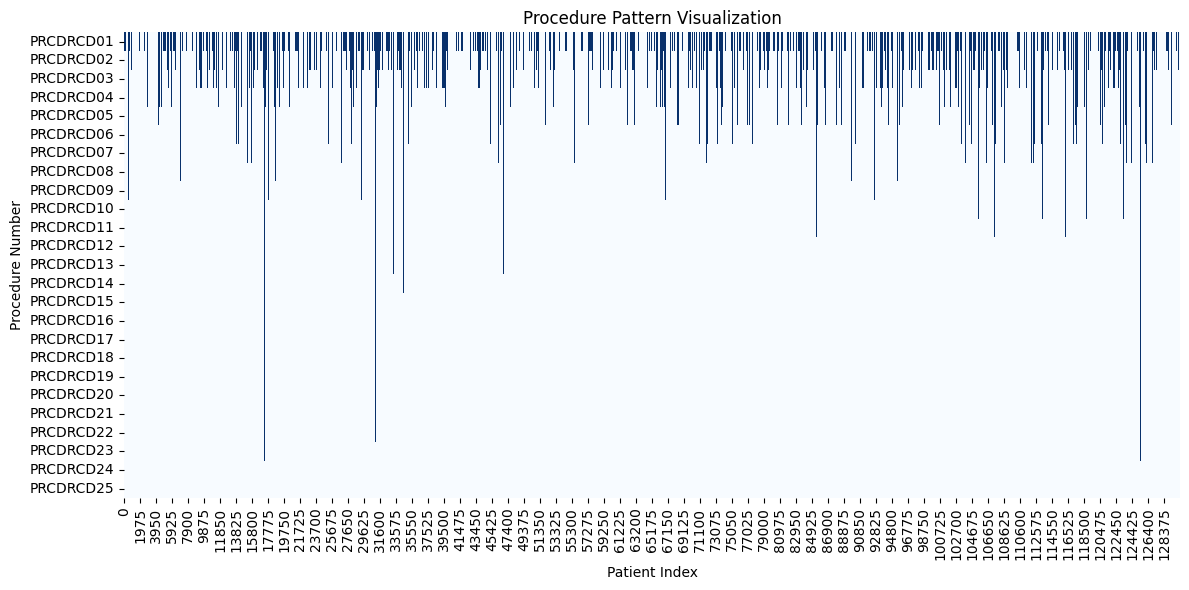

In [442]:
# Visualize procedure presence
# Create a matrix where 1 means procedure exists, 0 means not exists
proc_presence = pd.DataFrame()
for i in range(1, 26):
    col = f'PRCDRCD{str(i).zfill(2)}'
    proc_presence[col] = (~df_temp[col].isna() & (df_temp[col] != '')).astype(int)


# Visualize the procedure pattern
plt.figure(figsize=(12, 6))
sns.heatmap(proc_presence.T, cmap='Blues', cbar=False)
plt.title('Procedure Pattern Visualization')
plt.xlabel('Patient Index')
plt.ylabel('Procedure Number')
plt.tight_layout()
plt.show()

In [443]:
# by above analysis, we found that if a procedure is missing, all subsequent procedures are also missing. so nulls in procedure does't means that the procedure was not recorded but it means that the patient didn't have/need that procedure. 

In [444]:
# Let's check if the same pattern exists for diagnosis features
def check_diagnosis_pattern(row):
    """
    Checks if diagnoses follow the pattern:
    If diagnosis n is missing, then all diagnoses n+1 to 25 are also missing
    Returns True if pattern holds, False otherwise
    """
    diag_columns = [f'DGNSCD{str(i).zfill(2)}' for i in range(1, 26)]
    first_empty = None
    
    for i, col in enumerate(diag_columns):
        if pd.isna(row[col]) or row[col] == '':
            first_empty = i
            break
    
    if first_empty is None:  # All diagnoses are filled
        return True
    
    # Check if all diagnoses after first_empty are also empty
    for col in diag_columns[first_empty:]:
        if not pd.isna(row[col]) and row[col] != '':
            return False
    
    return True

In [445]:
df_temp  = df.copy()

# Apply the function to each row
df_temp['diag_follows_pattern'] = df_temp.apply(check_diagnosis_pattern, axis=1)

# Count pattern compliance
pattern_count = df_temp['diag_follows_pattern'].value_counts()
print("Diagnosis Pattern Compliance:")
print(pattern_count)
print(f"Percentage of rows following pattern: {100 * pattern_count.get(True, 0) / len(df_temp):.2f}%")

Diagnosis Pattern Compliance:
diag_follows_pattern
True    130296
Name: count, dtype: int64
Percentage of rows following pattern: 100.00%


In [446]:
# Diagnosis columns are also following the same pattern. 

# Now we can reduce these 50 columns to 2 columns. these columns will indicate that how many procedures/diagnosis were performed on the patient.

# this is the first and most simplest approach to reduce the number of columns.



In [447]:
# get all unique diagnosis codes
unique_diagnosis_codes = set()
all_diagnosis_codes = []
for i in range(1, 26):
    col = f'DGNSCD{str(i).zfill(2)}'
    unique_diagnosis_codes.update(df[col].dropna().unique())
    all_diagnosis_codes.extend(df[col].dropna())

print(f"Total unique diagnosis codes: {len(unique_diagnosis_codes)}")
print(f"all diagnosis codes: {len(all_diagnosis_codes)}")
# get all unique diagnosis codes
unique_procedure_codes = set()
all_procedure_codes = []
for i in range(1, 26):
    col = f'PRCDRCD{str(i).zfill(2)}'
    unique_procedure_codes.update(df[col].dropna().unique())
    all_procedure_codes.extend(df[col].dropna())

print(f"Total unique procedure codes: {len(unique_procedure_codes)}")
print(f"all procedures codes: {len(all_procedure_codes)}")

Total unique diagnosis codes: 9778
all diagnosis codes: 2178998
Total unique procedure codes: 4701
all procedures codes: 152469


##### Handling these columns

In [448]:
proc_columns = [f'PRCDRCD{str(i).zfill(2)}' for i in range(1, 26)]
diag_columns = [f'DGNSCD{str(i).zfill(2)}' for i in range(1, 26)]

In [449]:
df_count_based = df.copy()
df_position_based = df.copy()
df_grouped_codes = df.copy()

In [450]:

# Method 1: Count-Based Features

df_count_based['num_diagnoses'] = df_count_based[diag_columns].notna().sum(axis=1)
df_count_based['num_procedures'] = df_count_based[proc_columns].notna().sum(axis=1)


df_count_based.drop(columns=diag_columns + proc_columns, inplace=True)

In [451]:

# ----------------------------
# Method 2: Position-Based Features
# ----------------------------

# Primary diagnosis code
df_position_based['primary_diagnosis'] = df_position_based['DGNSCD01']

# If both diagnosis and procedure 01 are present, condition is treated
df_position_based['primary_condition_treated'] = df_position_based[['DGNSCD01', 'PRCDRCD01']].notna().all(axis=1).astype(int)

# Ratio of diagnoses that have procedures
def calculate_diag_proc_ratio(row):
    diag_count = 0
    treated_count = 0
    for i in range(1, 26):
        diag = row.get(f'DGNSCD{str(i).zfill(2)}')
        proc = row.get(f'PRCDRCD{str(i).zfill(2)}')
        if pd.notna(diag):
            diag_count += 1
            if pd.notna(proc):
                treated_count += 1
    return treated_count / diag_count if diag_count > 0 else 0

df_position_based['treatment_ratio'] = df_position_based.apply(calculate_diag_proc_ratio, axis=1)


# target encoding of primary diagnosis
primary_diag_target_encoding = df_position_based.groupby('primary_diagnosis')['Readmitted_30'].mean()
df_position_based['primary_diagnosis_encoded'] = df_position_based['primary_diagnosis'].map(primary_diag_target_encoding)

global_readmit_mean = df_position_based['Readmitted_30'].mean()
df_position_based['primary_diagnosis_encoded'] = df_position_based['primary_diagnosis_encoded'].fillna(global_readmit_mean)

df_position_based.drop(columns=['primary_diagnosis'], inplace=True)


df_position_based.drop(columns=diag_columns + proc_columns, inplace=True)

In [452]:
# ----------------------------
# Method 3: Group/Select Important Codes
# ----------------------------

# Reduce diagnosis codes to their first 3 characters to represent groups
for col in diag_columns:
    df_grouped_codes[col] = df_grouped_codes[col].astype(str).str[:3]

# Get the top 20 most frequent diagnosis code groups
top_diag_groups = pd.Series(df_grouped_codes[diag_columns].values.ravel()).value_counts().nlargest(20).index

# Create binary features for top 20 diagnosis code groups
for code in top_diag_groups:
    df_grouped_codes[f'diag_code_{code}'] = df_grouped_codes[diag_columns].apply(lambda x: code in x.values, axis=1).astype(int)

# Drop original diagnosis and procedure columns (optional for modeling)
df_grouped_codes = df_grouped_codes.drop(columns=diag_columns + proc_columns)


#### Readmitted_30

In [453]:
# check class imbalance in the target variable

C:\Users\shame\AppData\Local\Temp\ipykernel_19884\1464052039.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Readmitted_30', data=df, palette='Blues')


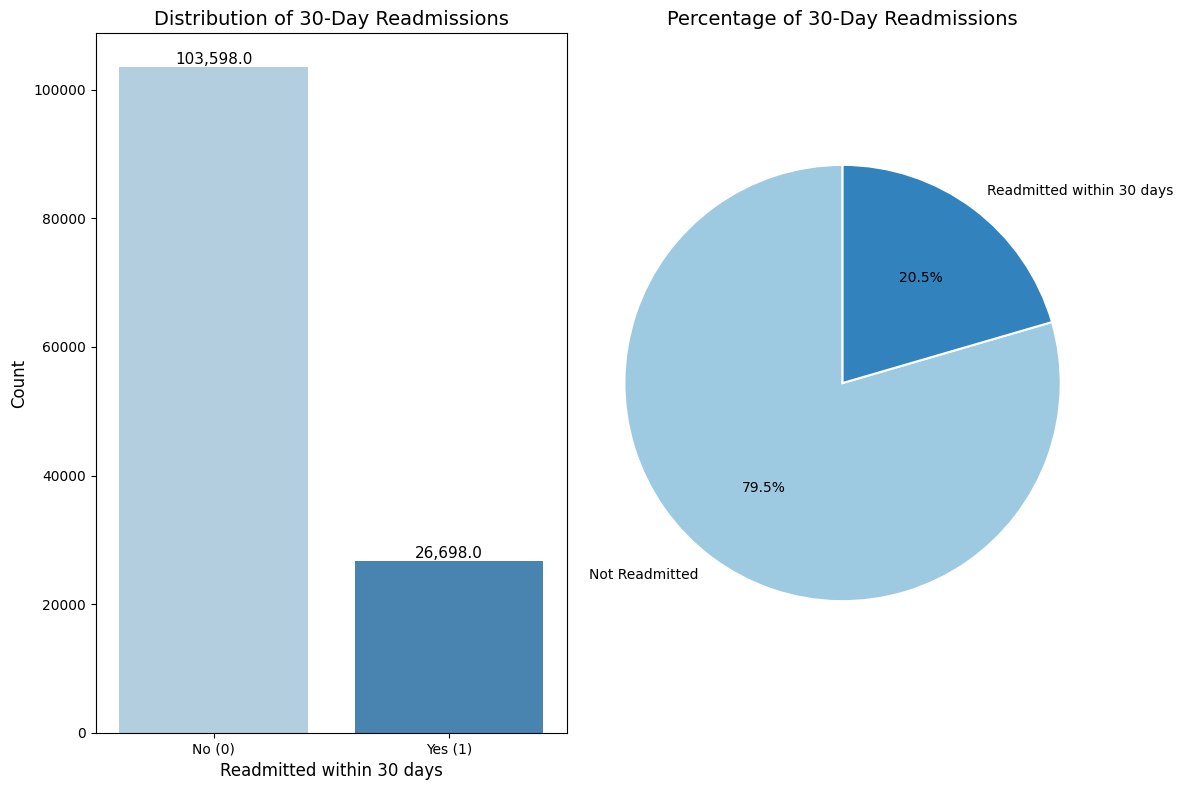

In [454]:
plt.figure(figsize=(12, 8))

# Create a countplot for Readmitted_30
plt.subplot(1, 2, 1)
sns.countplot(x='Readmitted_30', data=df, palette='Blues')
plt.title('Distribution of 30-Day Readmissions', fontsize=14)
plt.xlabel('Readmitted within 30 days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])

# Add count labels on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=11)

# Create a pie chart showing percentage distribution
plt.subplot(1, 2, 2)
readmit_counts = df['Readmitted_30'].value_counts()
labels = ['Not Readmitted', 'Readmitted within 30 days']
colors = ['#9ecae1', '#3182bd']
plt.pie(readmit_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
plt.title('Percentage of 30-Day Readmissions', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [455]:
readmission_rate = df['Readmitted_30'].mean() * 100
print(f"30-Day Readmission Rate: {readmission_rate:.2f}%")
print(f"Total Patients: {len(df):,}")
print(f"Readmitted Patients: {df['Readmitted_30'].sum():,}")
print(f"Non-readmitted Patients: {len(df) - df['Readmitted_30'].sum():,}")

30-Day Readmission Rate: 20.49%
Total Patients: 130,296
Readmitted Patients: 26,698
Non-readmitted Patients: 103,598


#### Removing class imbalace from training data

In [456]:
y = df['Readmitted_30']

In [457]:
X_countbased = df_count_based.drop([ 'Readmitted_30'], axis=1)
X_position_based = df_position_based.drop([ 'Readmitted_30'], axis=1)
X_grouped_codes = df_grouped_codes.drop([ 'Readmitted_30'], axis=1)

In [458]:
from sklearn.model_selection import train_test_split

X_train_count, X_test_count, y_train, y_test = train_test_split(X_countbased, y, test_size=0.2, random_state=42)

X_train_position, X_test_position, y_train, y_test = train_test_split(X_position_based, y, test_size=0.2, random_state=42)

X_train_group, X_test_group, y_train, y_test = train_test_split(X_grouped_codes, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)

X_resampled_count, y_resampled_count = adasyn.fit_resample(X_train_count, y_train)

# 

c:\Users\shame\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [460]:
X_resampled_position, y_resampled_position = adasyn.fit_resample(X_train_position, y_train)


c:\Users\shame\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [461]:
X_resampled_group, y_resampled_group = adasyn.fit_resample(X_train_group, y_train)


c:\Users\shame\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [462]:
y_resampled_count.info()

<class 'pandas.core.series.Series'>
RangeIndex: 165308 entries, 0 to 165307
Series name: Readmitted_30
Non-Null Count   Dtype
--------------   -----
165308 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


# Model Training 

In [ ]:
# use following df's to get data

# X_resampled_count, y_resampled_count ,X_test_count , y_test
# X_resampled_position, y_resampled_position , X_test_position , y_test
# X_resampled_group, y_resampled_group , X_test_group , y_test

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import StackingClassifier
    


In [ ]:
def train_logistic_regression(X_train, X_test, y_train, y_test):

    # Initialize and train the model
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)

    # Make predictions
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict_proba(X_test)[:,1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    print("----------------------------------------")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return lr, metrics

# Store metrics for each dataset
lr_metrics_dict = {}


print("Training Logistic Regression on Count-Based Features...")
lr_model1, lr_metrics_dict['dataset1'] = train_logistic_regression(X_resampled_count,X_test_count,y_resampled_count, y_test)

print("Training Logistic Regression on position...")
lr_model1, lr_metrics_dict['dataset2'] = train_logistic_regression(X_resampled_position,X_test_position,y_resampled_count, y_test)

print("Training Logistic Regression on group...")
lr_model1, lr_metrics_dict['dataset3'] = train_logistic_regression(X_resampled_group,X_test_group,y_resampled_count, y_test)

In [ ]:
X_resampled_count, y_resampled_count ,X_test_count , y_test

X_resampled_position, y_resampled_position , X_test_position , y_test

X_resampled_group, y_resampled_group , X_test_group , y_test

In [ ]:

def train_random_forest(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a Random Forest model
    Parameters:
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
    
    Returns:
        rf: Trained Random Forest model
        metrics: Dictionary containing evaluation metrics
    """
    # Initialize and train the model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:,1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Print results
    print("----------------------------------------")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return rf, metrics

# Store metrics for Random Forest models
rf_metrics_dict = {}

# Train and evaluate Random Forest on dataset 1
print("Training Random Forest on Count-Based Features...")
rf_model1, rf_metrics_dict['dataset1'] = train_random_forest(X_resampled_count,X_test_count,y_resampled_count, y_test)

print("Training Random Forest on position...")
lr_model1, rf_metrics_dict['dataset2'] = train_logistic_regression(X_resampled_position,X_test_position,y_resampled_count, y_test)

print("Training Random Forest on group...")
lr_model1, rf_metrics_dict['dataset3'] = train_logistic_regression(X_resampled_group,X_test_group,y_resampled_count, y_test)

In [ ]:

def train_xgboost(X_train, X_test, y_train, y_test):
    """
    Train and evaluate an XGBoost model
    Parameters:
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
    
    Returns:
        xgb: Trained XGBoost model
        metrics: Dictionary containing evaluation metrics
    """
    # Initialize and train the model
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb.predict(X_test)
    y_pred_proba = xgb.predict_proba(X_test)[:,1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Print results
    print("----------------------------------------")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return xgb, metrics

# Store metrics for XGBoost models
xgb_metrics_dict = {}

# Train and evaluate XGBoost on dataset 1
print("Training XGBoost on Count-Based Features...")
xgb_model1, xgb_metrics_dict['dataset1'] = train_xgboost(X_resampled_count,X_test_count,y_resampled_count, y_test)


print("Training XGBoost on position...")
lr_model1, xgb_metrics_dict['dataset2'] = train_logistic_regression(X_resampled_position,X_test_position,y_resampled_count, y_test)

print("Training XGBoost on group...")
lr_model1, xgb_metrics_dict['dataset3'] = train_logistic_regression(X_resampled_group,X_test_group,y_resampled_count, y_test)


In [ ]:

def train_catboost(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a CatBoost model
    Parameters:
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
    
    Returns:
        cat: Trained CatBoost model
        metrics: Dictionary containing evaluation metrics
    """
    # Initialize and train the model
    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(X_train, y_train)

    # Make predictions
    y_pred = cat.predict(X_test)
    y_pred_proba = cat.predict_proba(X_test)[:,1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Print results
    print("----------------------------------------")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return cat, metrics

# Store metrics for CatBoost models
cat_metrics_dict = {}

# Train and evaluate CatBoost on dataset 1
print("Training CatBoost on Count-Based Features...")
cat_model1, cat_metrics_dict['dataset1'] = train_catboost(X_resampled_count,X_test_count,y_resampled_count, y_test)

print("Training CatBoost on position...")
lr_model1, cat_metrics_dict['dataset2'] = train_logistic_regression(X_resampled_position,X_test_position,y_resampled_count, y_test)

print("Training CatBoost on group...")
lr_model1, cat_metrics_dict['dataset3'] = train_logistic_regression(X_resampled_group,X_test_group,y_resampled_count, y_test)


In [ ]:

def train_knn(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a K-Nearest Neighbors model
    Parameters:
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
    
    Returns:
        knn: Trained KNN model
        metrics: Dictionary containing evaluation metrics
    """
    # Initialize and train the model
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    # Make predictions
    y_pred = knn.predict(X_test)
    y_pred_proba = knn.predict_proba(X_test)[:,1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Print results
    print("----------------------------------------")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return knn, metrics

# Store metrics for KNN models
knn_metrics_dict = {}

# Train and evaluate KNN on dataset 1
print("Training KNN on Count-Based Features...")
knn_model1, knn_metrics_dict['dataset1'] = train_knn(X_resampled_count,X_test_count,y_resampled_count, y_test)


print("Training KNN on position...")
lr_model1, knn_metrics_dict['dataset2'] = train_logistic_regression(X_resampled_position,X_test_position,y_resampled_count, y_test)

print("Training KNN on group...")
lr_model1, knn_metrics_dict['dataset3'] = train_logistic_regression(X_resampled_group,X_test_group,y_resampled_count, y_test)


In [ ]:


# x,y = df



# train_test_split

# models:
#     1. logistic
#     2. random forest
#     3. xgboost
#     4. catboost
#     5. lightgbm
#     6. knn
#     7. decision tree
#     8. naive bayes
#     9. svm
#     10. ensemble (stacking, bagging, boosting)
#     11. neural network (RNN,LSTM)
# apply hyper parameter tuning to all models 


# evaluation metrics:
#     1. accuracy
#     2. precision
#     3. recall
#     4. f1 score
#     5. roc auc score
#     7. classification report


# chose the best model based on the evaluation metrics and predict the test.csv

